#### Load data

In [1]:
import os
import json
from tqdm import tqdm
from llama_index.core.schema import TextNode

label_to_number = {level: i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
node_dir_path = os.path.abspath('../../database/gpt-4o-batch-all-target')
node_file_path = os.path.join(node_dir_path, 'all.jsonl')
# Get the total file size
file_size = os.path.getsize(node_file_path)

id_to_level = {}
# save_file = open('texts_and_labels.jsonl', 'w', encoding='utf-8')

# Read the file and track progress based on bytes read
with open(node_file_path, 'r') as file:
    with tqdm(total=file_size, desc=f'Loading {node_file_path.split(os.path.sep)[-1]}', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for line in file:
            node_data = json.loads(line)
            node = TextNode.from_dict(node_data)
            # data = {
            #     'text':node.text,
            #     'label': label_to_number[node.metadata['level']]
            # }
            id_to_level[node.id_] = node.metadata['level']
            # json.dump(data, save_file)
            # save_file.write('\n')
            # Update progress bar based on bytes read
            pbar.update(len(line))
# save_file.close()

Loading all.jsonl: 100%|██████████| 209G/209G [3:59:54<00:00, 15.6MB/s]   


In [2]:
save_file = open('./data/id_to_labels.jsonl', 'w', encoding='utf-8')

for node_id, label in tqdm(id_to_level.items(), desc='saving id_to_labels.jsonl'):
    data = {
        'node_id': node_id,
        'label': label
    }
    json.dump(data, save_file)
    save_file.write('\n')
save_file.close()

saving id_to_labels.jsonl: 100%|██████████| 1789351/1789351 [00:22<00:00, 79920.13it/s]


In [1]:
import os
import json
import pandas as pd
qar_file_name = 'gpt-4o-batch-all-target_extract_gpt-4o-QAExtractor-batch_pid_0.jsonl.csv' # modify each time
qar_dataset_path = os.path.join(os.path.abspath('../../.save/gpt-4o-batch-all-target_1_parser/question'), qar_file_name)
def get_context(input_text):
    lines = input_text.split('\n')
    for idx, text in enumerate(lines):
        if text.startswith('Context'):
            # The next line will be the context string
            if idx + 1 < len(lines):
                return lines[idx + 1]
df = pd.read_csv(qar_dataset_path)

In [5]:
id_to_level = {}
with open('./data/id_to_labels.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        id_to_level[data['node_id']] = data['label']

save_file = open('./data/ids_questions_and_labels.jsonl', 'w', encoding='utf-8')
for row_id, obj_str in enumerate(df['objs']):
    objs = json.loads(obj_str)
    if len(objs) == 0:
        print(f"[Invalid rqa pairs] No objs found at row id: {row_id} which should have {df['qar_num'][row_id]} questions")
    for obj in objs:
        label = id_to_level[df['node_id'][row_id]]
        data = {
            'node_id': df['node_id'][row_id],
            'question': obj['Question'],
            'label': label
        }
        json.dump(data, save_file)
        save_file.write('\n')
save_file.close()

[Invalid rqa pairs] No objs found at row id: 432 which should have 1 questions


#### Resample dataset

In [6]:
import os
from tqdm import tqdm
import json

ids = []
questions = []
labels = []
label_to_number = {level: i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
texts_and_labels_file_path = './data/ids_questions_and_labels.jsonl'
file_size = os.path.getsize(texts_and_labels_file_path)
with open(texts_and_labels_file_path, 'r') as file:
    with tqdm(total=file_size, desc=f'Loading {texts_and_labels_file_path.split(os.path.sep)[-1]}', unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for line in file:
            data = json.loads(line)
            ids.append(data['node_id'])
            questions.append(data['question'])
            labels.append(label_to_number[data['label']])
            # Update progress bar based on bytes read
            pbar.update(len(line))

Loading ids_questions_and_labels.jsonl: 100%|██████████| 195k/195k [00:00<00:00, 34.3MB/s]


In [13]:
import random
import pandas as pd
# Step 1: Create a DataFrame with texts and labels for easier manipulation
df = pd.DataFrame({
    'id': ids,
    'question': questions,
    'label': labels
})

# Step 2: Find out how many 'document' labels there are
label_counts = df['label'].value_counts()
document_count = label_counts.min()

# Step 3: Get random samples from each of the other label groups to match the 'document' count
random_document = df[df['label'] == 0].sample(n=document_count, random_state=42)
random_paragraph = df[df['label'] == 1].sample(n=document_count, random_state=42)
random_section = df[df['label'] == 2].sample(n=document_count, random_state=42)
random_multi_sentences = df[df['label'] == 3].sample(n=document_count, random_state=42)

# Step 4: Combine the randomly sampled groups with the original 'document' group
balanced_df = pd.concat([
    random_document,
    random_paragraph,
    random_section,
    random_multi_sentences
])
# Step 5: Shuffle the final DataFrame to randomize the order of the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_texts = balanced_df['question'].tolist()
balanced_labels = balanced_df['label'].tolist()
balanced_ids = balanced_df['id'].tolist()


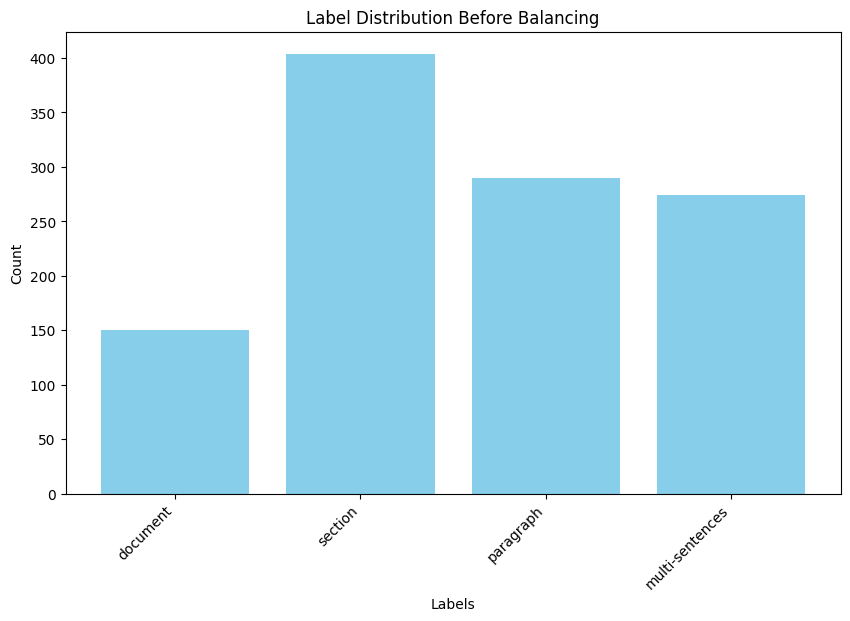

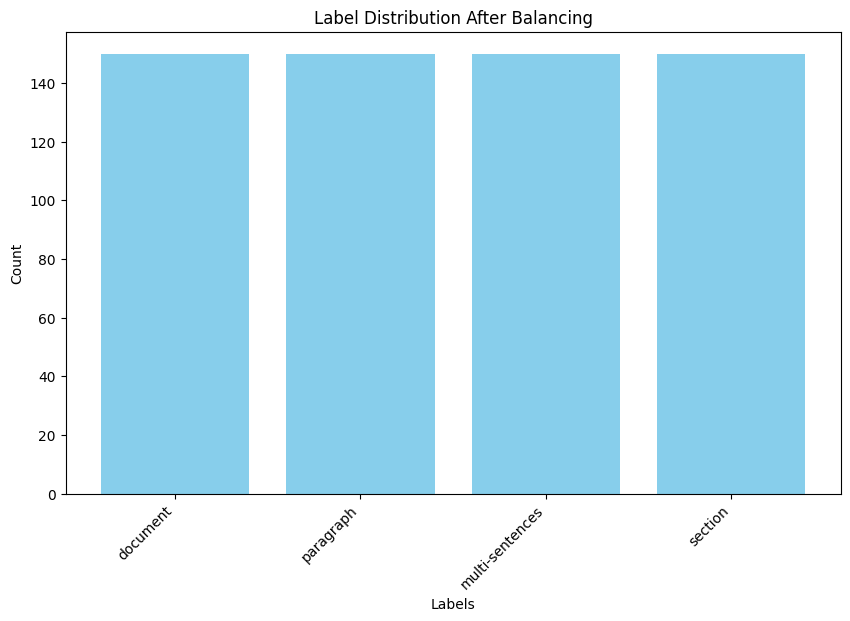

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

label_to_number = {level: i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
number_to_label = {v:k for k,v in label_to_number.items()}
# Step 1: Count the occurrences of each label
label_counts_before = Counter([number_to_label[l] for l in labels])  # Original distribution
label_counts_after = Counter([number_to_label[l] for l in balanced_labels])  # After balancing (resampling)

# Step 2: Visualization function
def plot_label_distribution(label_counts, title):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate label names for better readability
    plt.show()

# Step 3: Plot label distribution before and after balancing
plot_label_distribution(label_counts_before, 'Label Distribution Before Balancing')
plot_label_distribution(label_counts_after, 'Label Distribution After Balancing')

#### Generate dataset_dict

In [16]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Step 1: First split - 80% train, 20% temp (to later split into valid and test)
train_ids, temp_ids, train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_ids,
    balanced_texts, 
    balanced_labels, 
    test_size=0.2,  # 20% for temp (valid + test)
    random_state=42  # Seed for reproducibility
)

# Step 2: Split temp into 50% valid, 50% test (resulting in 10% valid, 10% test from original)
valid_ids, test_ids, valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    temp_ids,
    temp_texts, 
    temp_labels, 
    test_size=0.5,  # Split the temp data equally into valid and test (10% each)
    random_state=42
)

# Step 3: Create datasets from splits
train_dataset = Dataset.from_dict({"id": train_ids, "text": train_texts, "label": train_labels})
valid_dataset = Dataset.from_dict({"id": valid_ids, "text": valid_texts, "label": valid_labels})
test_dataset = Dataset.from_dict({"id": test_ids, "text": test_texts, "label": test_labels})

# Step 4: Combine into a DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test": test_dataset
})

# Save the dataset to disk
dataset_save_path = './dataset_dict'
dataset_dict.save_to_disk(dataset_save_path)
print(f'Dataset saved to {dataset_save_path}')

Saving the dataset (0/1 shards):   0%|          | 0/480 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset saved to ./dataset_dict


In [17]:
dataset_dict.shape

{'train': (480, 3), 'valid': (60, 3), 'test': (60, 3)}

#### Load parameters

In [1]:
dataset_save_path = './dataset_dict'
model_save_dir = "./results"
num_epochs = 5
batch_size = 32
lr = 5e-5

Map:   0%|          | 0/21148 [00:00<?, ? examples/s]

Map:   0%|          | 0/9064 [00:00<?, ? examples/s]

#### Load dataset

In [11]:
from datasets import load_from_disk
loaded_dataset_dict = load_from_disk(dataset_save_path)

#### Tokenize datasets

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", cache_dir='/home/zhengzheng/work/.hf_cache')
tokenized_dataset_dict = loaded_dataset_dict.map(
    lambda x: tokenizer(x['text'], truncation=True), 
    batched=True
)

tokenized_dataset_dict = tokenized_dataset_dict.remove_columns(["text"])
tokenized_dataset_dict = tokenized_dataset_dict.rename_column("label", "labels")
tokenized_dataset_dict.set_format("torch")

tokenized_dataset_dict

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_dataset_dict['train'], shuffle=True, batch_size=batch_size, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_dataset_dict['test'], batch_size=batch_size, collate_fn=data_collator)

#### Load model

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4, cache_dir='/home/zhengzheng/work/.hf_cache')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [17]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [18]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

#### Train

In [42]:
from train import save_epoch_evaluate

progress_bar = tqdm(range(num_training_steps), desc='training ...')

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    # Evaluate on training data
    save_epoch_evaluate(model, train_dataloader, "Train", epoch + 1, "evaluate_results", device)
    # Evaluate on testing data
    save_epoch_evaluate(model, eval_dataloader, "Test", epoch + 1, "evaluate_results", device)

    # Save the model and tokenizer
    model_save_path = os.path.join(model_save_dir, str(epoch * len(train_dataloader)))
    if os.path.exists(model_save_path):
        os.remove(model_save_path)
    os.makedirs(model_save_path)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

#### Visulize results

In [1]:
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_result(evaluate_type, epoch_num):
    """
    Visualize classification results by generating a classification report and confusion matrix.
    
    Args:
        evaluate_type (str): The type of evaluation (e.g., "Train" or "Test").
        epoch_num (int): The epoch number for which results should be visualized.
        target_names (list): List of target class names for the classification report.

    """
    target_names = ['document', 'section', 'paragraph', 'multi-sentences']
    # Load predictions and true labels
    predictions_path = f"./evaluate_results/{evaluate_type}_predictions_epoch_{epoch_num}.npy"
    labels_path = f"./evaluate_results/{evaluate_type}_true_labels_epoch_{epoch_num}.npy"

    if not os.path.exists(predictions_path) or not os.path.exists(labels_path):
        print(f"Error: Files for epoch {epoch_num} not found in {evaluate_type}.")
        return
    
    predictions = np.load(predictions_path)
    labels = np.load(labels_path)

    # Generate classification report
    report = classification_report(labels, predictions, target_names=target_names)
    print(f"Classification Report for {evaluate_type} at epoch {epoch_num}:\n")
    print(report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix for {evaluate_type} - Epoch {epoch_num}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



Classification Report for Train at epoch 1:

                 precision    recall  f1-score   support

       document       0.74      0.82      0.78      5252
        section       0.79      0.71      0.75      5252
      paragraph       0.85      0.73      0.79      5371
multi-sentences       0.77      0.87      0.81      5273

       accuracy                           0.78     21148
      macro avg       0.79      0.78      0.78     21148
   weighted avg       0.79      0.78      0.78     21148



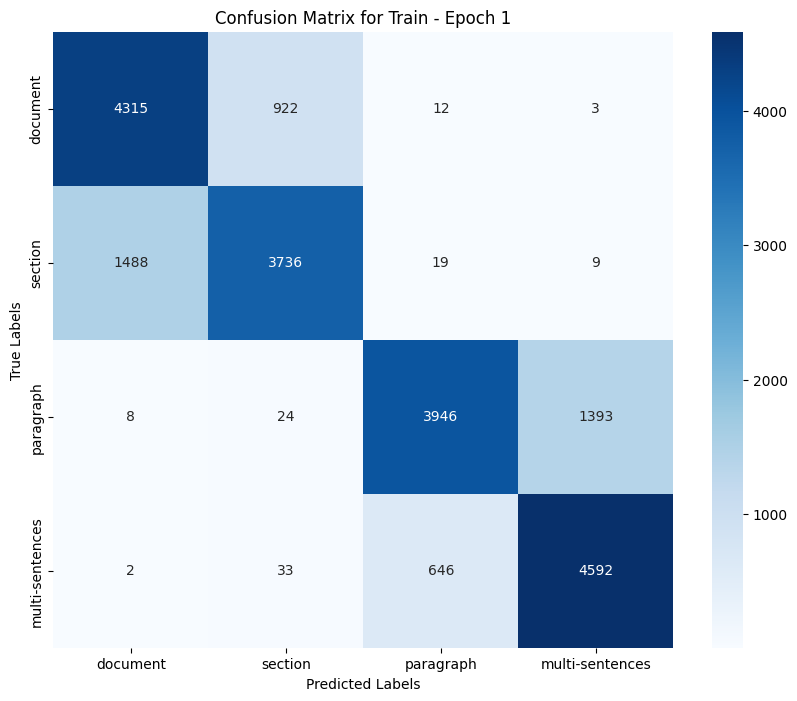

Classification Report for Test at epoch 1:

                 precision    recall  f1-score   support

       document       0.70      0.78      0.74      2301
        section       0.74      0.67      0.70      2301
      paragraph       0.81      0.69      0.75      2182
multi-sentences       0.75      0.84      0.79      2280

       accuracy                           0.75      9064
      macro avg       0.75      0.74      0.74      9064
   weighted avg       0.75      0.75      0.74      9064



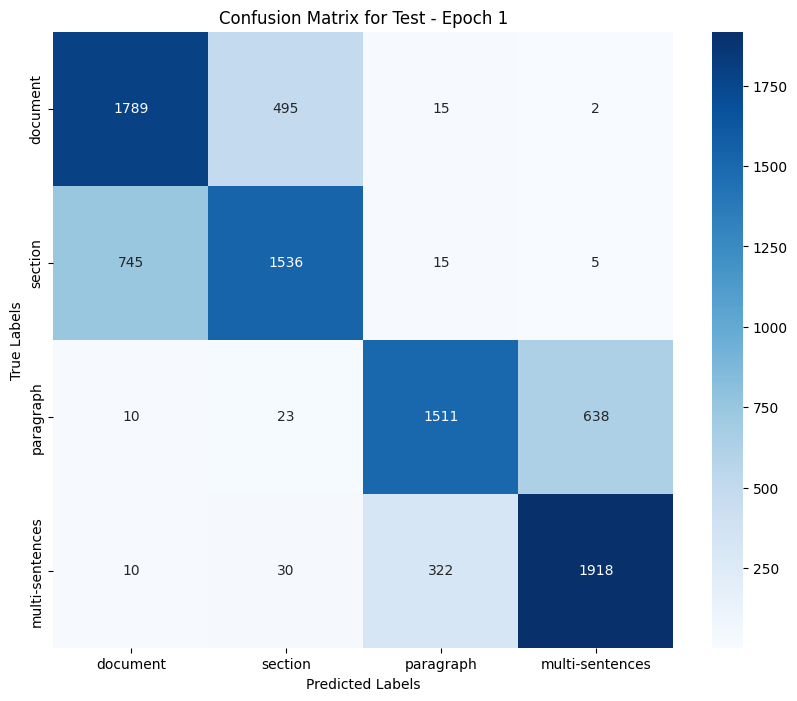

Classification Report for Train at epoch 2:

                 precision    recall  f1-score   support

       document       0.87      0.89      0.88      5252
        section       0.89      0.86      0.88      5252
      paragraph       0.87      0.86      0.86      5371
multi-sentences       0.86      0.87      0.86      5273

       accuracy                           0.87     21148
      macro avg       0.87      0.87      0.87     21148
   weighted avg       0.87      0.87      0.87     21148



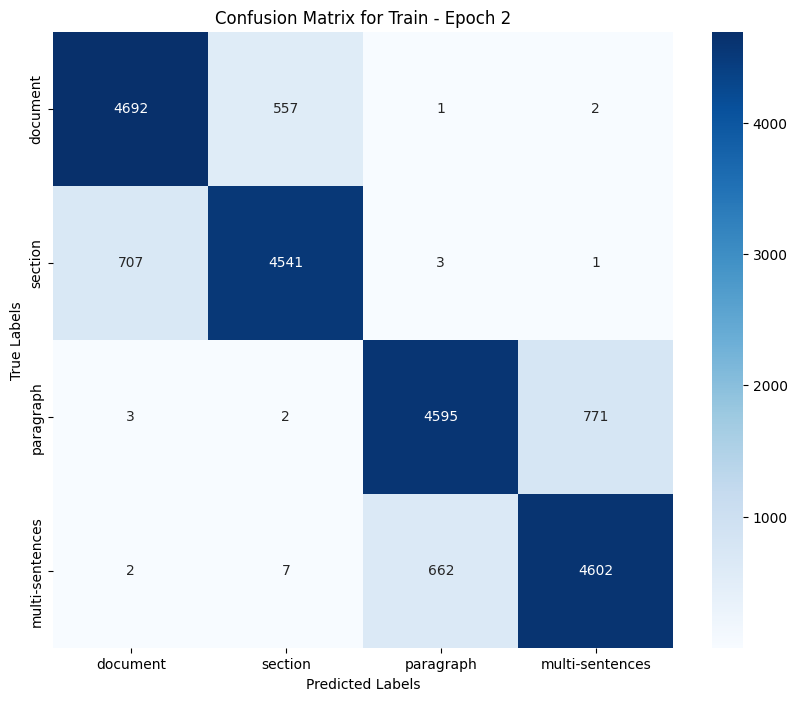

Classification Report for Test at epoch 2:

                 precision    recall  f1-score   support

       document       0.75      0.76      0.76      2301
        section       0.75      0.75      0.75      2301
      paragraph       0.79      0.74      0.76      2182
multi-sentences       0.77      0.81      0.79      2280

       accuracy                           0.76      9064
      macro avg       0.76      0.76      0.76      9064
   weighted avg       0.76      0.76      0.76      9064



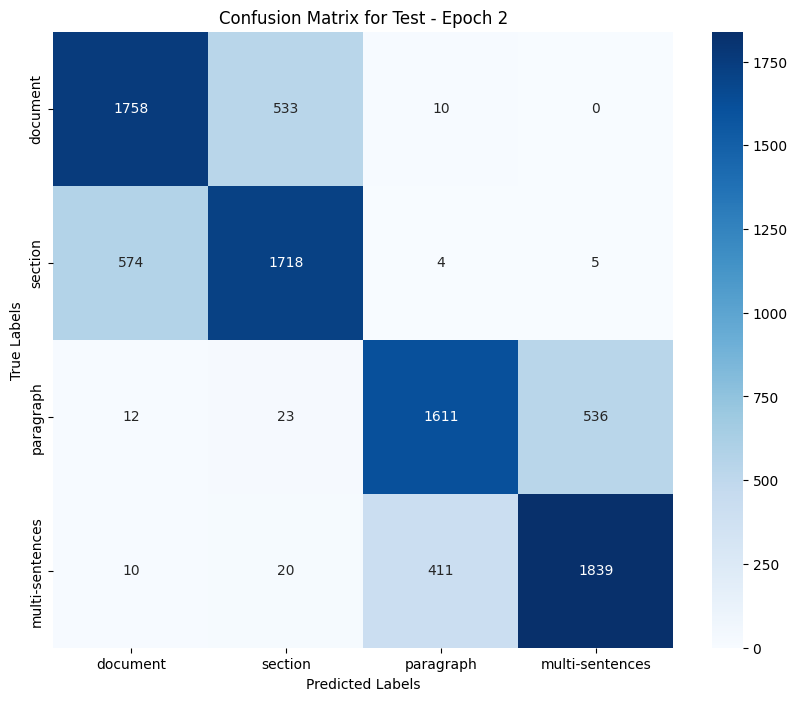

Classification Report for Train at epoch 3:

                 precision    recall  f1-score   support

       document       0.94      0.99      0.97      5252
        section       0.99      0.94      0.97      5252
      paragraph       0.94      0.98      0.96      5371
multi-sentences       0.98      0.93      0.96      5273

       accuracy                           0.96     21148
      macro avg       0.96      0.96      0.96     21148
   weighted avg       0.96      0.96      0.96     21148



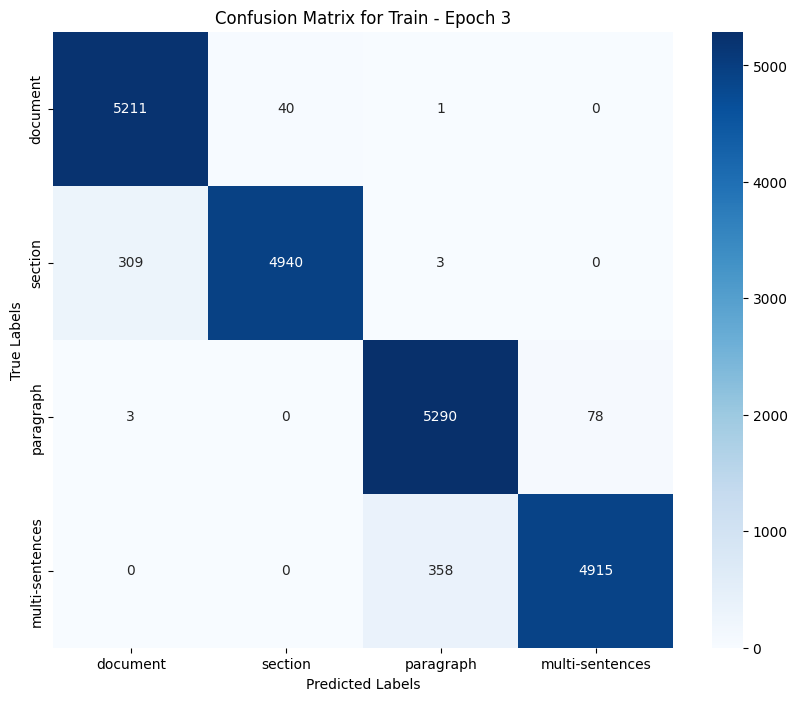

Classification Report for Test at epoch 3:

                 precision    recall  f1-score   support

       document       0.70      0.83      0.76      2301
        section       0.79      0.65      0.71      2301
      paragraph       0.72      0.80      0.76      2182
multi-sentences       0.79      0.71      0.75      2280

       accuracy                           0.75      9064
      macro avg       0.75      0.75      0.75      9064
   weighted avg       0.75      0.75      0.75      9064



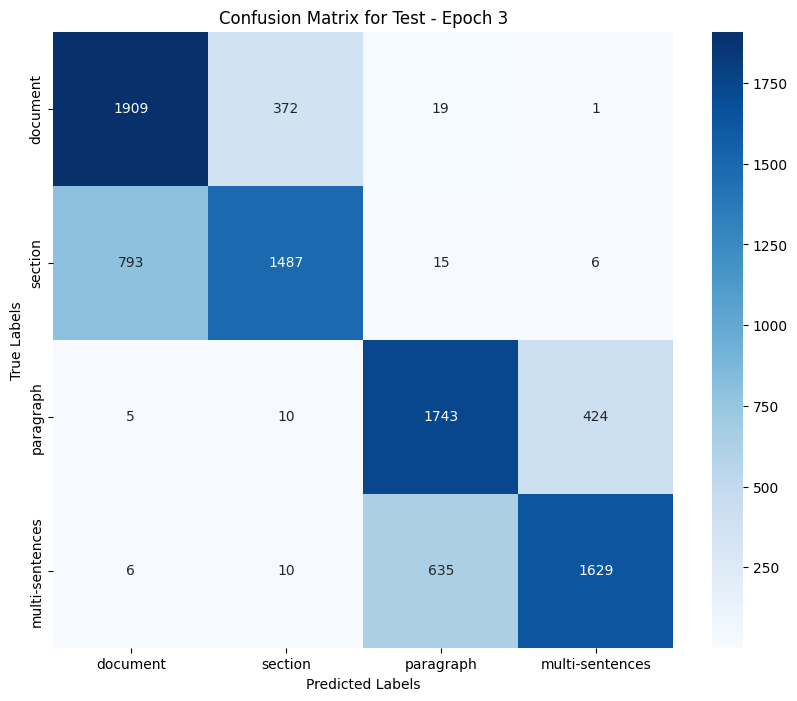

Classification Report for Train at epoch 4:

                 precision    recall  f1-score   support

       document       0.99      1.00      1.00      5252
        section       1.00      0.99      1.00      5252
      paragraph       0.99      1.00      0.99      5371
multi-sentences       1.00      0.99      1.00      5273

       accuracy                           1.00     21148
      macro avg       1.00      1.00      1.00     21148
   weighted avg       1.00      1.00      1.00     21148



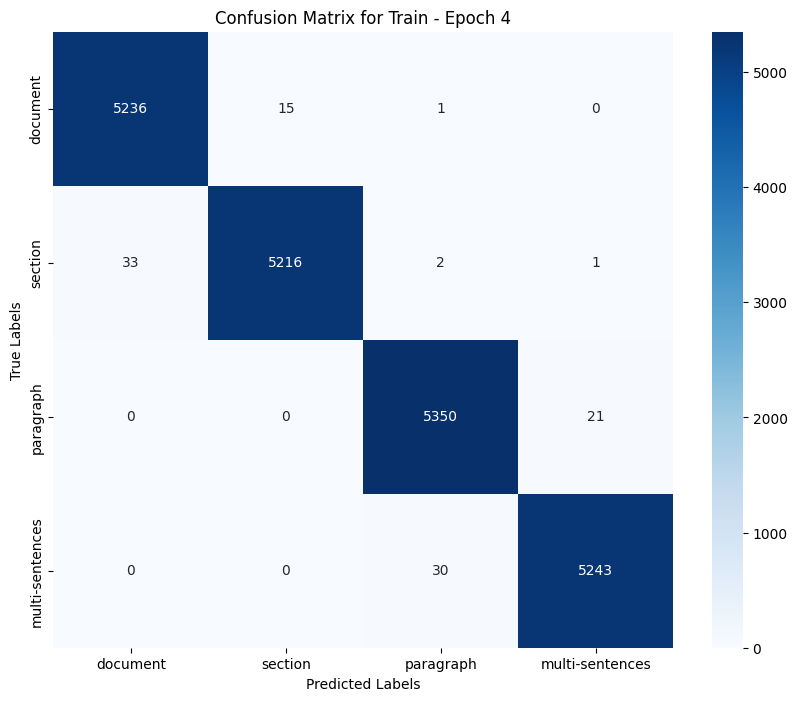

Classification Report for Test at epoch 4:

                 precision    recall  f1-score   support

       document       0.72      0.76      0.74      2301
        section       0.74      0.71      0.72      2301
      paragraph       0.77      0.73      0.75      2182
multi-sentences       0.76      0.80      0.78      2280

       accuracy                           0.75      9064
      macro avg       0.75      0.75      0.75      9064
   weighted avg       0.75      0.75      0.75      9064



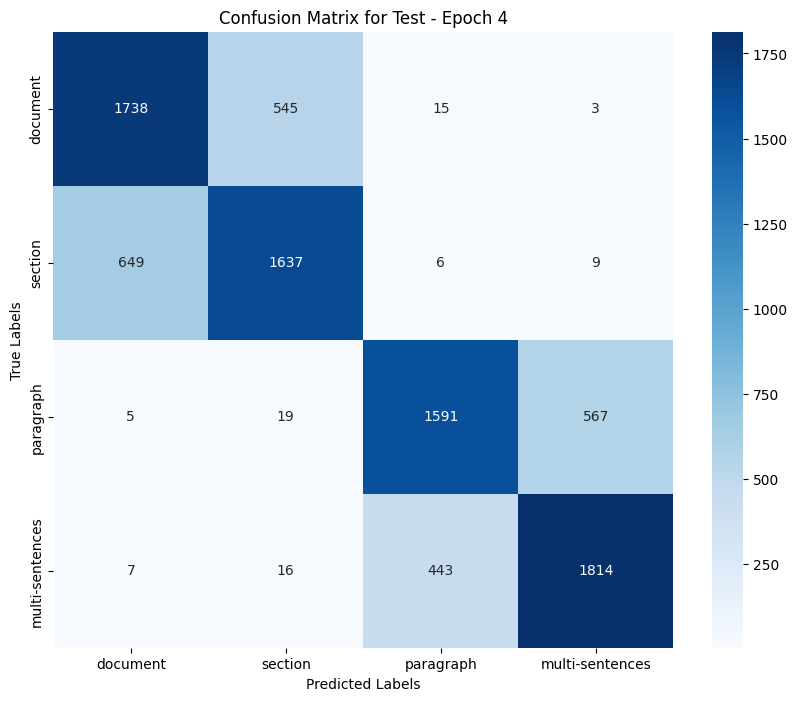

Classification Report for Train at epoch 5:

                 precision    recall  f1-score   support

       document       1.00      1.00      1.00      5252
        section       1.00      1.00      1.00      5252
      paragraph       1.00      1.00      1.00      5371
multi-sentences       1.00      1.00      1.00      5273

       accuracy                           1.00     21148
      macro avg       1.00      1.00      1.00     21148
   weighted avg       1.00      1.00      1.00     21148



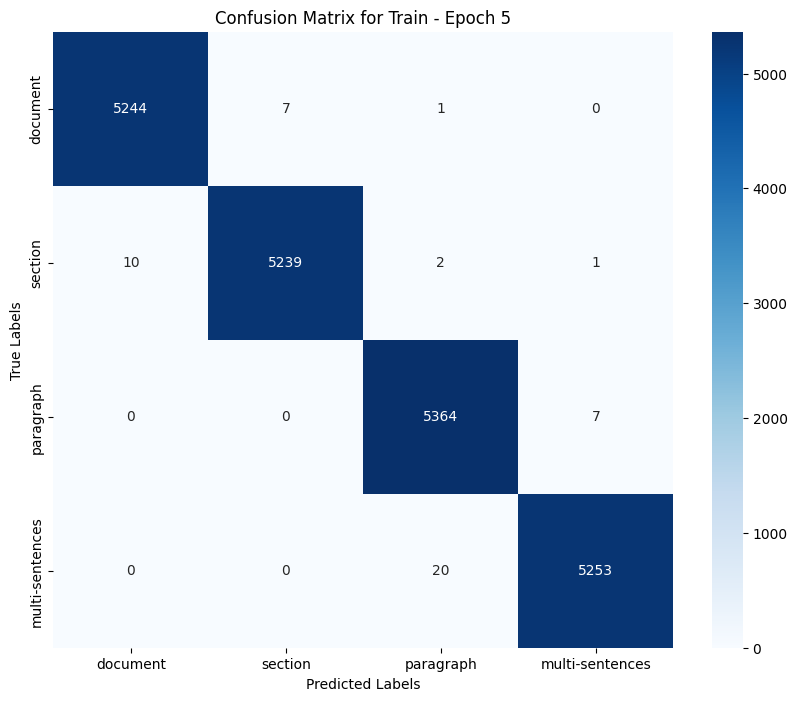

Classification Report for Test at epoch 5:

                 precision    recall  f1-score   support

       document       0.74      0.73      0.73      2301
        section       0.73      0.74      0.73      2301
      paragraph       0.77      0.74      0.75      2182
multi-sentences       0.76      0.79      0.78      2280

       accuracy                           0.75      9064
      macro avg       0.75      0.75      0.75      9064
   weighted avg       0.75      0.75      0.75      9064



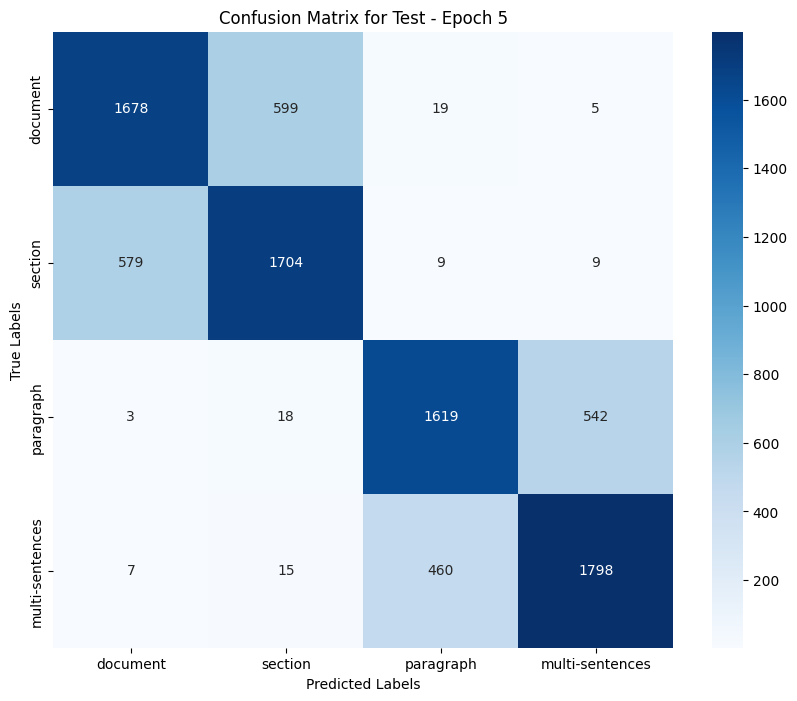

In [2]:
for epoch_num in range(1, 6):
    for evalutate_type in ['Train', 'Test']:
        visualize_result(evalutate_type, epoch_num)

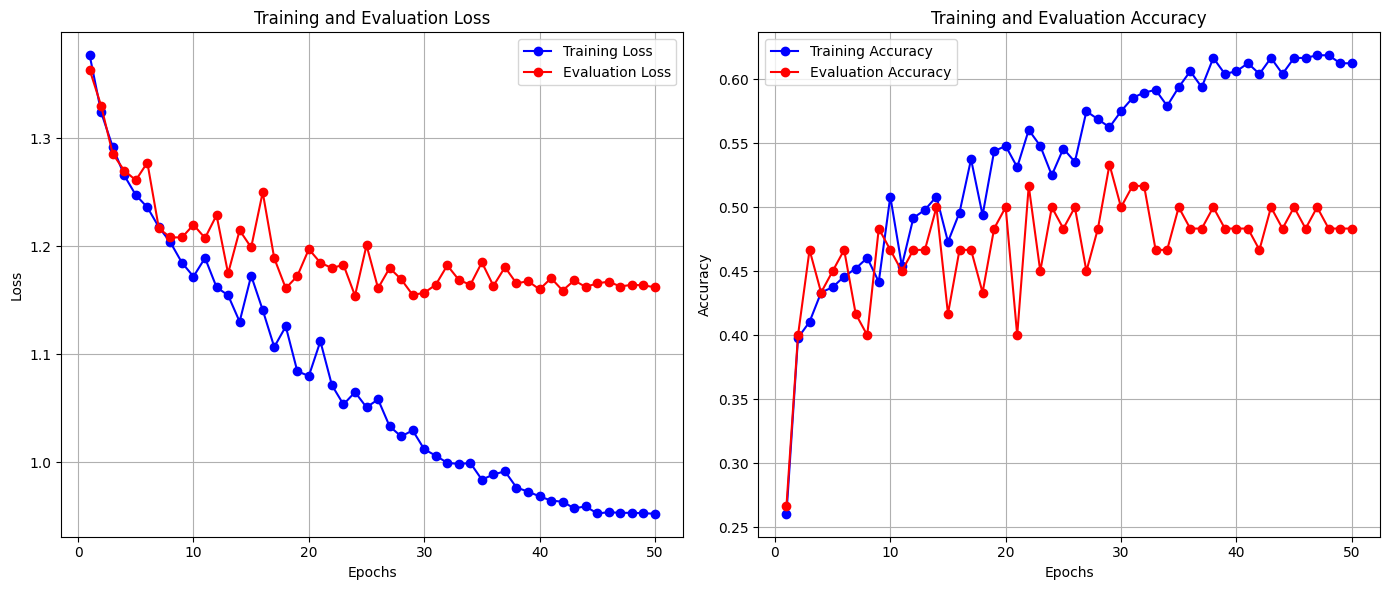

In [1]:
import csv
import matplotlib.pyplot as plt

# Initialize empty lists for training and evaluation data
epochs = []
training_loss = []
training_accuracy = []
evaluation_loss = []
evaluation_accuracy = []

# Read the CSV file
csv_file_path = "training_evaluation_log.csv"

with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        epochs.append(int(row[0]))  # Epoch
        training_loss.append(float(row[1]))  # Train Loss
        training_accuracy.append(float(row[2]))  # Train Accuracy
        evaluation_loss.append(float(row[3]))  # Eval Loss
        evaluation_accuracy.append(float(row[4]))  # Eval Accuracy

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(epochs, training_loss, label='Training Loss', marker='o', color='b')
ax1.plot(epochs, evaluation_loss, label='Evaluation Loss', marker='o', color='r')
ax1.set_title('Training and Evaluation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', color='b')
ax2.plot(epochs, evaluation_accuracy, label='Evaluation Accuracy', marker='o', color='r')
ax2.set_title('Training and Evaluation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [2]:
max(evaluation_accuracy)

0.5333333333333333

### Model size analysis

In [15]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from configs.load_config import load_configs
from huggingface_hub import HfApi

# Initialize the Hugging Face API

load_configs()
api = HfApi()

# Search for models related to text-classification
models = api.list_models(filter="text-classification", sort="downloads")

from transformers import AutoModelForSequenceClassification, AutoConfig

def format_params(num):
    """Format the number of parameters in M or B."""
    if num >= 1e9:
        return f"{num / 1e9:.2f}B"  # Format as billions
    elif num >= 1e6:
        return f"{num / 1e6:.2f}M"  # Format as millions
    else:
        return str(num)  # Return as is for smaller numbers

In [ ]:
from tqdm import tqdm
# Assuming `models` is a list of model IDs
model_param_list = []

start_num = 0
end_num = 1000
with tqdm(total=end_num-start_num, desc="checking model...") as pbar:
    for i, model in enumerate(models):
        if i < start_num: continue
        if i >= end_num: break
        print(i)
        try:
            config = AutoConfig.from_pretrained(model.modelId)
            model_instance = AutoModelForSequenceClassification.from_config(config)

            num_params = sum(p.numel() for p in model_instance.parameters())
            formatted_params = format_params(num_params)

            model_param_list.append((model.modelId, num_params, formatted_params))
        except:
            pass
        pbar.update(1)

# Sort the list by the number of parameters (second item in tuple)
sorted_models = sorted(model_param_list, key=lambda x: x[1])

# Print sorted models
for i, (model_id, num_params, formatted_params) in enumerate(sorted_models):
    if i > 100:
        break
    print(f"Model: {model_id}, Number of parameters: {formatted_params}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
